In [2]:
from util import info
import numpy as np
import os
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
plt.style.use(['dark_background'])

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
bin_dir = r"C:\Users\zfj\data\021923B\func"

data = np.load(os.path.join(bin_dir,'spots_interp.npy'))
labels = np.load(os.path.join(bin_dir,'spots_loc.npy'))
xn = np.load(os.path.join(bin_dir,'spots_ti.npy'))

data = np.moveaxis(data,1,2)

In [4]:
#drop bad cells
data = data[:,:,np.mean(np.any(np.isnan(data), axis=1), axis=0) < .2]

#fill missing
data[np.isnan(data)] = 0.


ncells = data.shape[-1]

#filter epochs
data = data[500:]
labels = labels[500:]

In [5]:
cv = KFold(5, shuffle=True, random_state=0)
train, test = list(cv.split(data, labels))[0]

xtrain, xtest = data[train], data[test]
ytrain, ytest = labels[train,None,:], labels[test,None,:]

In [6]:
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((2736, 50, 84), (2736, 1, 2), (684, 50, 84), (684, 1, 2))

In [8]:
# tmri = layers.Input((None,ncells))
# ffns = []
# cnv1 = tmri
# for _ in range(2):
#     for i in range(6):
#         cnv1 = layers.SeparableConv1D(32, 2, dilation_rate=2**i, padding='causal')(cnv1)
#         cnv1 = layers.LayerNormalization()(cnv1)
#         cnv1 = layers.Activation('relu')(cnv1)
#         cnv1 = layers.SeparableConv1D(ncells, 2, dilation_rate=2**i, padding='causal')(cnv1)
#         cnv1 = layers.LayerNormalization()(cnv1)
#         cnv1 = layers.Add()([cnv1, tmri])
#         ffns.append(cnv1)
#     cnv1 = layers.Add()([*ffns, tmri])
# ffnt = layers.Activation('sigmoid')(cnv1)
# ffnt = layers.Dense(2)(ffnt)


# mod = keras.Model(inputs=tmri, outputs = ffnt)
# mod.summary()

xtrain = xtrain.reshape((xtrain.shape[0],-1))
ytrain = ytrain.reshape((ytrain.shape[0],2))
xtest = xtest.reshape((xtest.shape[0],-1))
ytest = ytest.reshape((ytest.shape[0],2))


tmi = layers.Input(xtrain.shape[-1])
# cnv = layers.Concatenate()([layers.Conv1D(1, int(i), padding='causal', activation='relu')(tmi) for i in np.linspace(8.0, 64.0, 16)])
tmii = layers.LayerNormalization()(tmi)
tmii = layers.Dense(512)(tmii)

ffn = layers.Dense(512, activation='relu')(tmi)
ffn = layers.Add()([tmii, ffn])
ffn = layers.LayerNormalization()(ffn)
for i in range(6):
    ffn = layers.Dense(512, activation='relu')(ffn)
    ffn = layers.Add()([tmii, ffn])
    ffn = layers.LayerNormalization()(ffn)
# ffn = layers.Dense(512, activation='relu')(ffn)
# ffn = layers.Add()([tmii, ffn])
ffn = layers.Dense(2)(ffn)
mod = keras.Model(inputs=tmi, outputs = ffn)
mod.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4200)]       0           []                               
                                                                                                  
 layer_normalization_24 (LayerN  (None, 4200)        8400        ['input_2[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 dense_1 (Dense)                (None, 512)          2150912     ['layer_normalization_24[0][0]'] 
                                                                                                  
 dense_2 (Dense)                (None, 512)          2150912     ['input_2[0][0]']          

In [9]:
mod.compile(
    loss = keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
)
history = mod.fit(xtrain, ytrain, validation_data=(xtest,ytest), epochs=200, callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=10, verbose=1))



Epoch 1/200
86/86 [==============================] - 3s 21ms/step - loss: 163.3645 - val_loss: 122.3097
Epoch 2/200
86/86 [==============================] - 2s 18ms/step - loss: 117.3362 - val_loss: 109.4842
Epoch 3/200
86/86 [==============================] - 2s 18ms/step - loss: 102.0997 - val_loss: 110.0090
Epoch 4/200
86/86 [==============================] - 2s 18ms/step - loss: 93.6163 - val_loss: 107.2732
Epoch 5/200
86/86 [==============================] - 2s 18ms/step - loss: 84.9961 - val_loss: 108.2361
Epoch 6/200
86/86 [==============================] - 2s 18ms/step - loss: 81.3248 - val_loss: 111.7782
Epoch 7/200
86/86 [==============================] - 2s 18ms/step - loss: 77.2206 - val_loss: 108.3111
Epoch 8/200
86/86 [==============================] - 1s 17ms/step - loss: 70.5364 - val_loss: 111.5594
Epoch 9/200
86/86 [==============================] - 1s 17ms/step - loss: 68.1610 - val_loss: 111.5321
Epoch 10/200
86/86 [==============================] - 1s 17ms/step - l

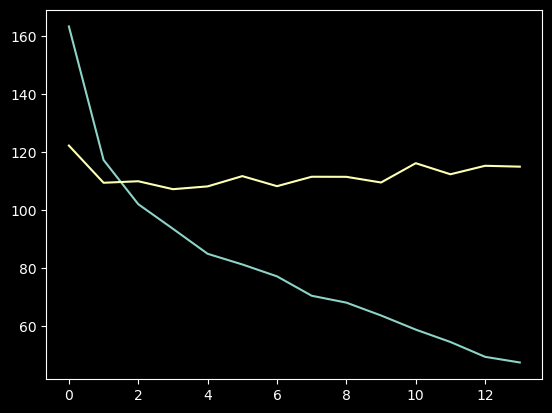

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [11]:
# np.sqrt(158), 2**5
ptest = mod.predict(xtest)

# ptest[:,-1,:]

22/22 [==============================] - 0s 5ms/step


In [12]:
ptest = ptest.reshape((ptest.shape[0],-1,ptest.shape[-1]))
ytest = ytest.reshape((ytest.shape[0],-1,ytest.shape[-1]))

# ptest
# plt.plot(ptest[0,:,0])
# plt.axhline(ytest[0,0,0], 0, 50)
ptest.shape, ytest.shape

err = np.sqrt(np.sum((ptest[:,-1,:] - ytest[:,0,:])**2, axis=1))

# edir = np.arctan2(ptest[:,-1,1] - ytest[:,0,1], ptest[:,-1,0] - ytest[:,0,0])
edir = np.arctan2(ytest[:,-1,1] - ptest[:,-1,1], ytest[:,-1,0] - ptest[:,-1,0])

In [83]:
#randomly permute the ptest
# calculate the average error
err_b = np.empty(1000)
for k in range(1000):
    err_b[k]= np.sqrt(np.sum((np.random.permutation(ptest)[:,-1,:] - ytest[:,0,:])**2, axis=1)).mean()


(28.64563524087312, 27.287400419143474)

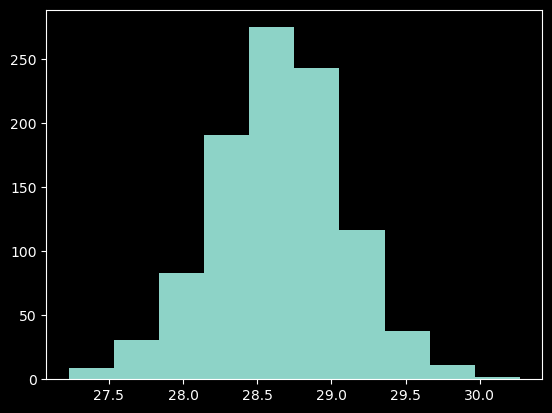

In [86]:
plt.hist(err_b)
np.mean(err_b),np.percentile(err_b,.05)

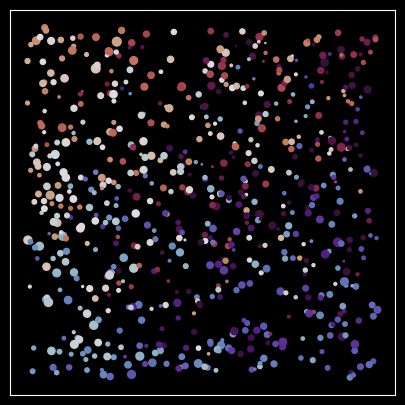

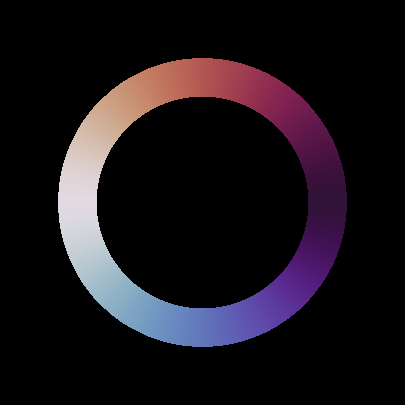

12.633204492104548


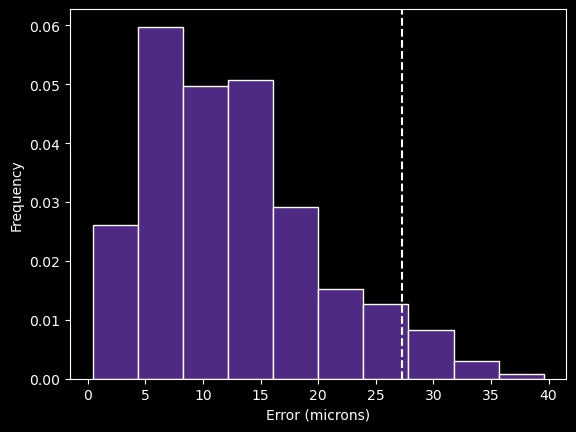

In [91]:
# _,axs = plt.subplots(1,2,figsize=(12,5))
fig = plt.figure(figsize=(6,5))

# ax = plt.subplot(121)
sc = plt.scatter(ytest[:,0,0], ytest[:,0,1], err, c=edir/np.pi*180, cmap='twilight')
plt.axis('square')
plt.xticks([])
plt.yticks([])


# fig.colorbar(sc, ax=ax)

plt.figure(figsize=(6,5))
# ax = plt.gca()
ax = plt.subplot( projection='polar')

import matplotlib as mpl
from matplotlib import cm

# Define colormap normalization for 0 to 2*pi
norm = mpl.colors.Normalize(-np.pi, np.pi) 

# Plot a color mesh on the polar plot
# with the color set by the angle

n = 2000  #the number of secants for the mesh
t = np.linspace(-np.pi,np.pi,n)   #theta values
r = np.linspace(.6,.7,2)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
c = tg                         #define color values as theta value
im = ax.pcolormesh(t, r, c.T,norm=norm, cmap='twilight')  #plot the colormesh on axis with colormap

ax.axis('off')
ax.set_ylim(0,1)



# # plt.colorbar()
plt.show()
plt.hist(err, density=True, color='#4E2A84',edgecolor='w')

# plt.axvline(np.percentile(err_b,.05),0,1,color='w',zorder=-1)
plt.axvline(np.percentile(err_b,.05),0,1,color='w',linestyle='--')
plt.xlabel('Error (microns)')
plt.ylabel('Frequency')


print(err.mean())

(-46.19270513648888, 39.49263328616772, -41.61279144391682, 44.07254697873978)

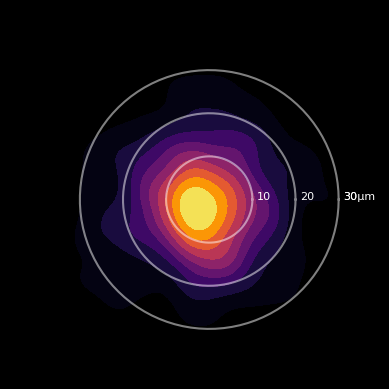

In [169]:
from seaborn import kdeplot

# plt.figure().add_subplot(projection='polar')
# sc = plt.scatter(edir, err, cmap='twilight')

cbar=False

for i in range(1,4):
    th = np.linspace(0,2*np.pi,100)
    plt.plot(10*i*np.cos(th), 10*i*np.sin(th), 'w', alpha=.5)
    plt.text(i*10+1, 0, f"{i*10}", fontsize=8)
plt.text(i*10+1, 0, f"{i*10}" + u'\u03bc' + 'm', fontsize=8)

kdeplot(x=err*np.cos(edir), y=err*np.sin(edir), fill=True, cmap='inferno', cbar=cbar)


# th = np.linspace(0,2*np.pi,5) + np.pi/4
# plt.plot(60*np.cos(th), 60*np.sin(th), 'w')


plt.axis('square')
plt.axis('off')

# plt.colorbar()



C:\Users\zfj\AppData\Local\Temp\ipykernel_11308\288656443.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('inferno')
C:\Users\zfj\AppData\Local\Temp\ipykernel_11308\288656443.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, pad=.001)
C:\Users\zfj\AppData\Local\Temp\ipykernel_11308\288656443.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f"{abs(i):0.0f}" for i in np.linspace(-35,0,8)])


(-33.037820762538544, 34.09115990883508, -32.99292971509217, 34.13605095628146)

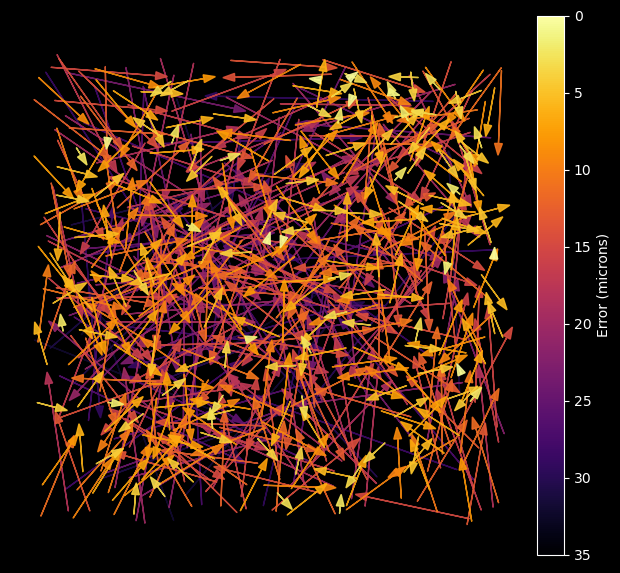

In [165]:
import matplotlib

cmap = matplotlib.cm.get_cmap('inferno')
norm = matplotlib.colors.Normalize(vmin=-35.0, vmax=0.0)

plt.figure(figsize=(8,7))

ii = np.flip(np.argsort(err))

for k in range(len(ytest)):
    i = ii[k]
    # plt.quiver(ytest[:,0,0], ytest[:,0,1], 300*(ptest[:,0,0] - ytest[:,0,0]), 300*(ptest[:,0,1] - ytest[:,0,1]), angles='xy')
    plt.arrow(ytest[i,0,0], ytest[i,0,1], ptest[i,0,0] - ytest[i,0,0], ptest[i,0,1] - ytest[i,0,1], color=cmap(norm(-err[i])), length_includes_head=True, head_width=1, alpha=.9)
# ytest.squeeze().shape, ptest.shape
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


cbar = plt.colorbar(sm, pad=.001)
cbar.set_label('Error (microns)')
cbar.ax.set_yticklabels([f"{abs(i):0.0f}" for i in np.linspace(-35,0,8)])

plt.axis('square')
plt.axis('off')
# plt.scatter(ytest[:,0,0], ytest[:,0,1])

In [100]:
## Null distribution

# # ptest
# # plt.plot(ptest[0,:,0])
# # plt.axhline(ytest[0,0,0], 0, 50)
# ptest.shape, ytest.shape

# # err = np.sqrt(np.sum((ptest[:,-1,:] - ytest[:,0,:])**2, axis=1))
# err = np.sqrt(np.sum((ptest[:,0,:] - ytest[:,0,:])**2, axis=1))

# # edir = np.arctan2(ptest[:,-1,1] - ytest[:,0,1], ptest[:,-1,0] - ytest[:,0,0])
# # edir = np.arctan2(ytest[:,-1,1] - ptest[:,-1,1], ytest[:,-1,0] - ptest[:,-1,0])
# edir = np.arctan2(ytest[:,0,1] - ptest[:,0,1], ytest[:,0,0] - ptest[:,0,0])

# # _,axs = plt.subplots(1,2,figsize=(12,5))
# fig = plt.figure(figsize=(12,5))

# ax = plt.subplot(121)
# sc = plt.scatter(ytest[:,0,0], ytest[:,0,1], err, c=edir/np.pi*180, cmap='twilight')


# # fig.colorbar(sc, ax=ax)

# ax = plt.subplot(122, projection='polar')

# import matplotlib as mpl
# from matplotlib import cm

# # Define colormap normalization for 0 to 2*pi
# norm = mpl.colors.Normalize(-np.pi, np.pi) 

# # Plot a color mesh on the polar plot
# # with the color set by the angle

# n = 200  #the number of secants for the mesh
# t = np.linspace(-np.pi,np.pi,n)   #theta values
# r = np.linspace(.6,1,2)        #radius values change 0.6 to 0 for full circle
# rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
# c = tg                         #define color values as theta value
# im = ax.pcolormesh(t, r, c.T,norm=norm, cmap='twilight')  #plot the colormesh on axis with colormap

# ax.set_yticklabels([])                   #turn of radial tick labels (yticks)
# ax.tick_params(pad=15,labelsize=24)      #cosmetic changes to tick labels
# ax.spines['polar'].set_visible(False)    #turn off the axis spine.
# ax.axis('off')


# # # plt.colorbar()
# plt.show()
# plt.hist(err, density=True)
# plt.xlabel('Error (microns)')
# plt.ylabel('Frequency')



In [31]:
ptest.shape, ytest.shape

((684, 50, 2), (684, 1, 2))

In [98]:
# for k in bootstrap:

# pick a,b

# project pred_b - pred_a onto b - a

# count if positive
# 

d = np.empty((1000,1000))
b = np.empty((1000,1000), dtype=bool)


for j in range(1000):
    for k in range(1000):
        i = np.random.choice(len(ytest), 2, replace=False)
        # print(ytest[i])
        
        d[k,j] = np.sqrt(np.sum((ytest[i[0],-1] - ytest[i[1],-1])**2))
        b[k,j] = np.dot((ytest[i[0],-1] - ytest[i[1],-1]), (ptest[i[0],-1] - ptest[i[1],-1])) > 0




C:\Users\zfj\AppData\Local\Temp\ipykernel_11308\3017898144.py:8: RuntimeWarning: Mean of empty slice.
  plt.hist(np.array([bj[jj].mean() for bj,jj in zip(b,j)]))
c:\Users\zfj\anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


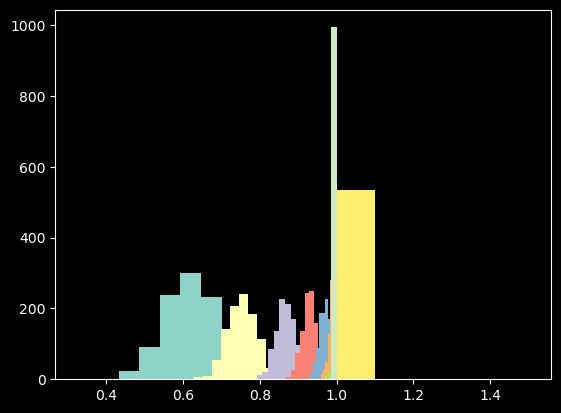

In [127]:
for i in range(10):
    j = (d > d.max()/10*i) & (d <= d.max()/10*(i+1))

    # j = (d[0] > d[0].max()/10*i) & (d[0] <= d[0].max()/10*(i+1))
    # j.shape, b.shape

    # print([len(b[jj]) for jj in j])
    plt.hist(np.array([bj[jj].mean() for bj,jj in zip(b,j)]))

# j.shape, b.shape
# j.shape

# b[j[1:]].shape

12.62978658437427


Text(0, 0.5, 'Discrimination accuracy')

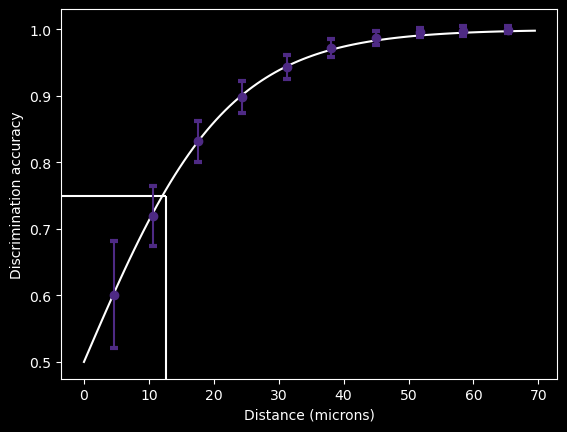

In [131]:
def logifunc(x,k):
    return 1. / (1 + np.exp(-k*x))

from scipy.optimize import curve_fit

popt, pcov = curve_fit(logifunc, d[0], b[0])
# print(popt, pcov)
ei = np.linspace(0, d[0].max(), 100)
e = logifunc(ei, popt)


# plt.scatter(d,b)
di = np.zeros(10)
bsi = np.zeros(10)
bi = np.zeros(10)
# ni = np.zeros(10)

for i in range(10):
    # j = (d[0] > d[0].max()/10*i) & (d[0] <= d[0].max()/10*(i+1))
    j = (d > d[0].max()/10*i) & (d <= d[0].max()/10*(i+1))
    
    # di[i] = np.array([d[jj].mean() for jj in j]).mean()
    di[i] = np.array([dj[jj].mean() for dj,jj in zip(d,j)]).mean()
    bi[i] = np.array([bj[jj].mean() for bj,jj in zip(b,j)]).mean()
    bsi[i] = np.array([bj[jj].mean() for bj,jj in zip(b,j)]).std()
    

    # di[i] = d[0][j[0]].mean()

    # # bsi[i] = b[0][j].std()
    
    # bi[i] = b[0][j[0]].mean()
    # ni[i] = np.count_nonzero(j)


plt.errorbar(di,bi,bsi, linestyle='none', marker='o', capsize=3, capthick=3)

plt.plot(ei,e)
xl = plt.xlim()
yl = plt.ylim()
plt.cla()

plt.vlines(ei[np.argwhere(e>=.75)[0,0]],yl[0],.75,color='w')
plt.hlines(.75, xl[0], ei[np.argwhere(e>=.75)[0,0]])        

# plt.scatter(d,b)

plt.plot(ei, e, 'w')
# plt.scatter(di,bi, color="#4E2A84", zorder=3)
plt.errorbar(di,bi,bsi, linestyle='none', marker='o', color="#4E2A84", capsize=3, capthick=3)
# plt.boxplot()



plt.xlim(xl)
plt.ylim(yl)

print(ei[np.argwhere(e>=.75)[0,0]])

plt.xlabel('Distance (microns)')
plt.ylabel('Discrimination accuracy')

In [132]:
ptest.shape

(684, 1, 2)

In [24]:
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
import visualkeras
visualkeras.layered_view(mod, legend=True, font=font, max_z=200)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'